In [1]:
import NetworkParameter as npm
import NetworkPrep as nwp
from SearchParameter import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors, patches
import matplotlib.colors as clr
import contextily as cx
from itertools import cycle
import warnings
import pickle
import rioxarray 
import xarray
from sigfig import round
import os
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran
from scipy.optimize import leastsq
from sklearn.linear_model import LinearRegression
from libpysal.weights.contiguity import Queen
from libpysal import examples
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import plot_local_autocorrelation
from splot._viz_utils import mask_local_auto, moran_hot_cold_spots, splot_colors
from scipy.interpolate import griddata
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore')
plt.style.use("seaborn-white")
sns.set_style('ticks')
color_platte = ['blue', '#81dbed', 'orange', '#93003a']

1. Fitted p and q

In [2]:
state = 'ca'; county = 'Los Angeles'; sname = 'losangeles'
year = 42; rep_num = 10; interval=10; people_per_node = 5; rexps = [1,3,10]; batch_set = [0,1,2,3]
tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))
demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
number_node = int(demo.POPULATION.sum()/people_per_node)
scale = number_node/demo.POPULATION.sum()
emp_curve = pd.read_csv(os.path.join( '..', 'data', state, county, 'tract_curve.csv'),converters={'tract': str})
emp_curve = pd.pivot_table(emp_curve, values='cum_reg', index=['tract'], columns=['year'], aggfunc="sum", fill_value=0).reset_index()
emp_curve = emp_curve[range(13)].sum(axis=0)/demo.POPULATION.sum()

(2.5885135352847623e-05, 0.0014044107879062821, 0.0023815779299217878) (0.1278022693306834, 0.06198325066258844, 0.14194936980651893)
(3.584453857257612e-06, 0.001353639449405769, 0.002187684781485659) (0.17418216172129575, 0.08376155224860668, 0.21248746788026077)
(1.415378637929531e-06, 0.0016687929102616815, 0.002222024816768718) (0.11336647292067316, 0.03161680684881868, 0.20851667026527548)
(1.7249048524653572e-06, 0.001542064395237483, 0.003378324959165035) (0.1313991607390681, 0.04050444942227243, 5.215789518253155e-05)


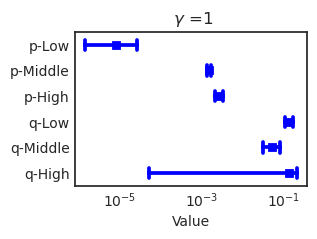

(0.0007623810617902104, 0.001400749021878491, 0.0023856031592143084) (0.03247571842939071, 0.053964374152901756, 0.09321642083193826)
(0.0006961334056951916, 0.0008679344994191178, 0.002329004481933462) (0.014591069935756412, 0.1541401299713705, 0.10276994497424438)
(0.0006967486631692866, 0.0015929923402936274, 0.0026231045124022667) (0.00034683541067273213, 0.028647295135007352, 0.06804548979544905)
(0.0007416867706464142, 0.000699077207702457, 0.0024027511093633424) (0.03502380306988669, 0.19533861415042283, 0.09736128772840681)


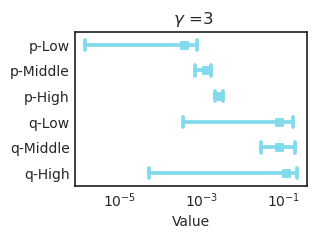

(0.0006673507761476013, 0.001850531412958382, 0.0030612655532246806) (0.04335513482507142, 0.0002047815279280112, 8.786777763526107e-05)
(0.0008459254323237658, 0.0017146965249187234, 0.0023531693450337524) (0.015081171587647513, 0.007521182061333163, 0.09131187044482088)
(0.0007558278247652565, 0.0009709311671406994, 0.0020627638856660024) (0.0004920207329010532, 0.15604920283262896, 0.1145104287762061)
(0.0007753878342633261, 0.0016008745697020177, 0.0022305726782256706) (0.02237653070249309, 0.02718474815428479, 0.10398389666793512)


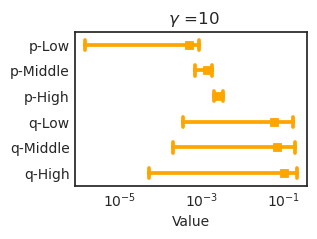

In [3]:
p_low_stars = []
q_low_stars = []
p_middle_stars = []
q_middle_stars = []
p_high_stars = []
q_high_stars = []
cl = ['blue', '#81dbed', 'orange']
for r in rexps:
    if r == 1:
        c = cl[0]
    if r == 3:
        c = cl[1]
    if r == 10:
        c = cl[2]
    for batch in batch_set:
        folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
        p_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder, 'parameters','p_value_star.pkl')), 'rb'), encoding='bytes')
        q_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder,'parameters','q_value_star.pkl')), 'rb'), encoding='bytes')
        p_low_stars.append(p_value_star[0])
        p_middle_stars.append(p_value_star[1])
        p_high_stars.append(p_value_star[2])
        
        q_low_stars.append(q_value_star[0])
        q_middle_stars.append(q_value_star[1])
        q_high_stars.append(q_value_star[2])
        print(p_value_star,q_value_star)

    pq_data = pd.DataFrame({'p-Low':p_low_stars,'p-Middle':p_middle_stars,'p-High':p_high_stars,'q-Low':q_low_stars,'q-Middle':q_middle_stars,'q-High':q_high_stars})
    pq_data = pd.melt(pq_data, value_vars=['p-Low','p-Middle','p-High','q-Low','q-Middle','q-High'],
            var_name='Type', value_name='Value')

    fig = plt.figure(figsize=(3,2))
    axs = fig.add_subplot()
    sns.pointplot(
        data=pq_data, x="Value", y="Type",
        errorbar=("pi", 100), capsize=0.4, markersize=5,
        color=c, linestyle="none", marker="s"
    )
    plt.title(' $\gamma$ ='+str(r))
    plt.ylabel('')
    plt.xscale("log")
    plt.savefig(os.path.join('..', 'figure', state, county, 'future_point_'+str(r)+'.pdf'),dpi=300,bbox_inches='tight')
    plt.show()

2. Adoption Curve 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


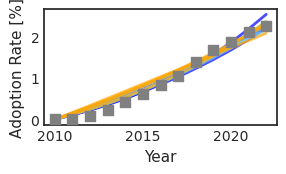

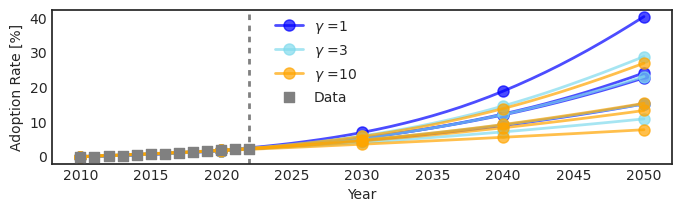

In [4]:
cl = ['blue', '#81dbed', 'orange']
count = 0; year = 13
fig = plt.figure(figsize=(3,1.5))
for r in rexps:
    if r == 1:
        c = cl[0]
    if r == 3:
        c = cl[1]
    if r == 10:
        c = cl[2]
    for batch in batch_set:
        curve_abms = []
        for rep in range(rep_num):
            folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
            sub_tract = (pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).sum(axis=0)[:year].values/demo.POPULATION.sum()
            curve_abms.append(sub_tract)
        curve_abms = np.array(curve_abms)
        plt.plot(np.arange(2010,2010+year),np.percentile(curve_abms,50,axis=0)*100, c = c, alpha =0.7, linewidth=2)
    count = count+1
    
plt.scatter(np.arange(2010,2023),emp_curve*100, s = 50, marker='s', c='grey',zorder=10)
plt.legend()
plt.xlabel('Year', fontsize =11)
plt.ylabel('Adoption Rate [%]', fontsize =11)
plt.savefig(os.path.join('..', 'figure', state, county, 'future_curve_zoom.pdf'),dpi=300,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8,2))
count = 0; year = 41
for r in rexps:
    if r == 1:
        c = cl[0]
    if r == 3:
        c = cl[1]
    if r == 10:
        c = cl[2]
    for batch in batch_set:
        curve_abms = []
        for rep in range(rep_num):
            folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
            sub_tract = (pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).sum(axis=0)[:year].values/demo.POPULATION.sum()
            curve_abms.append(sub_tract)
        curve_abms = np.array(curve_abms)
        plt.plot(np.arange(2010,2010+year),np.percentile(curve_abms,50,axis=0)*100, marker='o', alpha =0.7, c = c, markersize = 8, markevery=10, linewidth=2)
    count = count+1
    plt.plot([],[], c = c, marker='o', alpha =0.7, markersize = 8, linewidth=2,  label='$\gamma$ ='+str(r))
plt.axvline(2022, color="grey", dashes=(2, 2),linewidth=2)
plt.scatter(np.arange(2010,2023),emp_curve*100, s = 50, marker='s', c='grey',label='Data',zorder=10)
plt.legend(loc=(0.35,0.35))
plt.xlabel('Year')
plt.ylabel('Adoption Rate [%]')
plt.savefig(os.path.join('..', 'figure', state, county, 'future_curve_global.pdf'),dpi=300,bbox_inches='tight')
plt.show()

3. Moran Index

In [5]:
year = 42; interval = 5
emp_names = []; de_names = []; ds_names = []
for i in range(1,13):
    emp_names.append('EMP_'+str(i))

for i in range(1,year,interval):
    de_names.append('DE_'+str(i))
    ds_names.append('DS_'+str(i))

data_emp = pd.read_csv(os.path.join( '..', 'data', state, state+'_data.csv'),converters={'GEOID': str})
data_emp = data_emp.drop_duplicates(subset=['GEOID','CLASS'])
data_emp = pd.pivot_table(data_emp, values=emp_names+de_names+ds_names+['POPULATION'], index=['GEOID','COUNTY'], aggfunc="mean", fill_value=0).reset_index()
db = tract_shp.merge(data_emp,right_on='GEOID',left_on='GEOID',how='left').fillna(0)

population = demo.POPULATION.sum()

moran_emp = []; moran_de = []; moran_ds = []
db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
db = db[(db['COUNTY']==county)]
db.loc[(db['POPULATION'] == 0) | (db['POPULATION']<db['EMP_12']), ['POPULATION']] = 1e10
w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
for year_idx in range(1,13):
    moran_emp.append(esda.moran.Moran((db['EMP_'+str(year_idx)]/db['POPULATION']).clip(0, 1), w).I)      
moran_emp = np.array(moran_emp)

for year_idx in range(1,year,interval):
    moran_de.append(esda.moran.Moran((db['DE_'+str(year_idx)]/db['POPULATION']).clip(0,1), w).I)
    moran_ds.append(esda.moran.Moran((db['DS_'+str(year_idx)]/db['POPULATION']).clip(0,1), w).I)
moran_de = np.array(moran_de); moran_ds = np.array(moran_ds)

moran_abms = []; moran_abms5 = []; moran_abms95 = []
adoption_rate_abms = []

moran_scatter = []; adoption_scatter=[]; r_scatter = []
for r in rexps:
    moran_abm = []; adoption_rate_abm=[]
    for batch in batch_set:
        for rep in range(rep_num):
            folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
            sub_tract = (pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).reset_index().rename(columns={"index": "GEOID"})
            db = tract_shp.merge(sub_tract,right_on='GEOID',left_on='GEOID',how='left').fillna(0).merge(demo,right_on='GEOID',left_on='GEOID',how='left')
            db = db[(db['COUNTY']==county)]
            db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
            w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
            moran_year = []; adoption_rate_year = []
            for end in range(1,year,interval):
                db['rate'] = (db[end]/db['POPULATION']).fillna(np.mean(db[end]/db['POPULATION'])).clip(0,1)
                mv = esda.moran.Moran(db['rate'], w).I
                av = db[end].sum()/population
                moran_year.append(mv)
                adoption_rate_year.append(av)
                
                adoption_scatter.append(av)
                moran_scatter.append(mv)
                r_scatter.append(r)
                
            adoption_rate_abm.append(adoption_rate_year)
            moran_abm.append(moran_year)
        
    adoption_rate_abms.append(np.percentile(np.array(adoption_rate_abm),50,axis=0))
    moran_abms.append(np.percentile(np.array(moran_abm),50,axis=0))
    moran_abms5.append(np.percentile(np.array(moran_abm),0,axis=0))
    moran_abms95.append(np.percentile(np.array(moran_abm),100,axis=0))

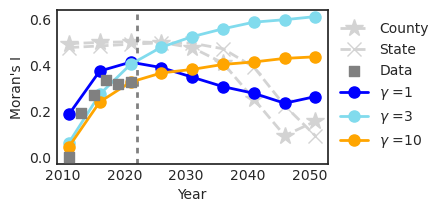

In [6]:
cl = ['blue', '#81dbed', 'orange']

fig = plt.figure(figsize=(3.5,2))
axs = fig.add_subplot()

plt.plot(np.arange(2011,2011+year,interval),moran_de, color = 'lightgrey', marker='*', markersize = 13, linewidth=2, linestyle='dashed', label='County')
plt.plot(np.arange(2011,2011+year,interval),moran_ds, color = 'lightgrey',  marker='x', markersize = 10,linewidth=2, linestyle='dashed',label='State')
plt.scatter(range(2011,2023,2),moran_emp[::2], color = 'grey', marker='s', label='Data',s = 55, zorder=10)
plt.axvline(2022, color="grey", dashes=(2, 2),linewidth=2)

for r,i in zip(rexps,range(len(rexps))):
    plt.plot(np.arange(2011,2011+year,interval), moran_abms[i], c = cl[i],marker='o', markersize = 8, linewidth=2, label='$\gamma$ ='+str(r))

plt.legend(ncol=1, bbox_to_anchor=[1, 1])
plt.xlabel('Year')
plt.ylabel('Moran\'s I')
plt.savefig(os.path.join('..', 'figure', state, county, 'future_curve_moran'+'.pdf'),dpi=300,bbox_inches='tight')

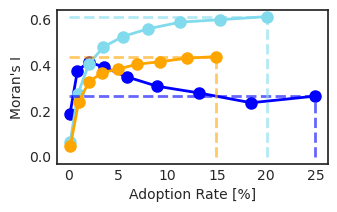

In [7]:
fig = plt.figure(figsize=(3.5,2))
plt.plot(adoption_rate_abms[0]*100, moran_abms[0], label='$\gamma$ ='+str(1), marker='o', markersize = 8, linewidth=2,  c = cl[0])
plt.plot(adoption_rate_abms[1]*100, moran_abms[1], label='$\gamma$ ='+str(3), marker='o', markersize = 8, linewidth=2,  c = cl[1])
plt.plot(adoption_rate_abms[2]*100, moran_abms[2], label='$\gamma$ ='+str(10), marker='o', markersize = 8, linewidth=2,  c = cl[2])

for i, color in enumerate(cl):
    plt.hlines(moran_abms[i][-1], 0, adoption_rate_abms[i][-1] * 100, linestyle='--', color=color, linewidth=2, alpha=0.6)
    plt.vlines(adoption_rate_abms[i][-1] * 100, 0, moran_abms[i][-1], linestyle='--', color=color, linewidth=2, alpha=0.6)

plt.xlabel('Adoption Rate [%]')
plt.ylabel('Moran\'s I')
plt.savefig(os.path.join('..', 'figure', state, county, 'future_scatter_moran.pdf'),dpi=300,bbox_inches='tight')

4. Adoption Curve

In [8]:
for r in rexps:
    for batch in batch_set:
        folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
        p_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder, 'parameters','p_value_star.pkl')), 'rb'), encoding='bytes')
        q_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder,'parameters','q_value_star.pkl')), 'rb'), encoding='bytes')
        
        p_low = p_value_star[0]; p_mid = p_value_star[1]; p_high = p_value_star[2]
        q_low = q_value_star[0]; q_mid = q_value_star[1]; q_high = q_value_star[2]
        
        p_value_star = [[p_low], [p_mid], [p_high]]
        q_value_star = [[q_low], [q_mid], [q_high]]
        
        par = [-1, r, 3, 3, 0, 100, 'none']
        anna = 'moran_'+str(r)+'_'+str(batch)
        func_name = anna+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
        spmob = SearchParameter(p_value_star, q_value_star, number_node, par, state, county, rep_num, 0, func_name)
        spmob.randomsearch()
        del spmob

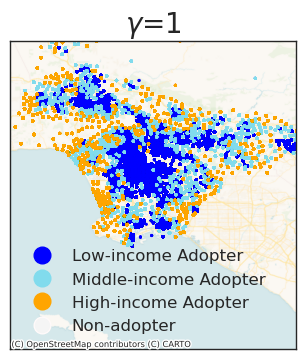

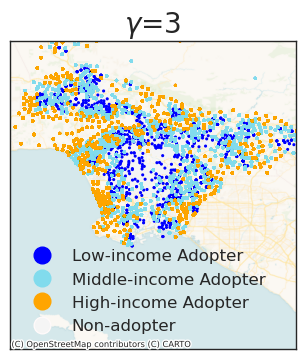

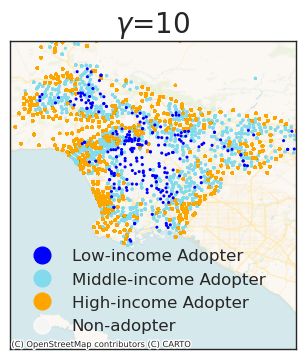

In [9]:
cl = ['blue', '#81dbed', 'orange']
demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
population = demo.POPULATION.sum()
number_node = int(population/people_per_node)
scale = number_node/demo.POPULATION.sum()

tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))
tract_shp = tract_shp.merge(demo,right_on='GEOID',left_on='GEOID',how='left')
tract_shp = tract_shp[tract_shp['COUNTY']==county]
node_class = np.load(os.path.join('..', 'result', state, county, 'node_list_'+str(number_node)+'.npy'))
node_tract = np.load(os.path.join('..', 'result', state, county, 'node_tract_'+str(number_node)+'.npy'))
tract_idx_dict = pd.read_csv(os.path.join('..', 'data',state, county,'tract_coord.csv')).reset_index().set_index('GEOID')['index'].to_dict()
tract_coord = pd.read_csv(os.path.join('..', 'data',state, county,'tract_coord.csv'),converters={'GEOID': str}).reset_index()[['GEOID','INTPTLON','INTPTLAT']]
tract_coord['INTPTLON'] = tract_coord['INTPTLON'].astype(float)
tract_coord['INTPTLAT'] = tract_coord['INTPTLAT'].astype(float)
tract_idx_dict = {v: '0'+str(k) for k, v in tract_idx_dict.items()}


for r in [1,3,10]:
    par = [-1, r, 3, 3, 0, 100, 'none']
    folder = 'moran_'+str(r)+'_'+str(0)+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
    edge_list = np.load(os.path.join('..', 'result', state, county, 'edge_list_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)+'.npy'))
    n_node = len(np.unique(edge_list))
    nodes = list(range(n_node))
    node_color = []
    node_place = []
    
    data = []
    for bn in batch_set:
        for rn in range(rep_num):
            folder = 'moran_'+str(r)+'_'+str(bn)+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
            agent_tract = pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'agent_curve_'+str(rn)+'.csv'),index_col=0).reset_index()
            agent_tract['rep'] = rn;  agent_tract['batch'] = bn
            data.append(agent_tract)
    data = pd.concat(data)
    data = data[(data['adoption_time']>-1)&(data['adoption_time']<41)]
    data_freq = pd.pivot_table(data, values='adoption_time', index=['index'], aggfunc="count")
    node_adopt = data_freq[data_freq['adoption_time']>=8].index.unique()

    nc = 'whitesmoke'
    for i,c in zip(nodes,node_class): 
        if i in node_adopt:
            node_color.append(cl[c])
        else: 
            node_color.append(nc)
        node_place.append(tract_idx_dict[node_tract[i]])
    cords = pd.DataFrame(node_place,columns=['GEOID']).merge(tract_coord, left_on='GEOID', right_on='GEOID')[['INTPTLON','INTPTLAT']].values
    
    vis = pd.DataFrame({'lon':cords[:,0],'lat':cords[:,1],'color':node_color})

    fig, ax = plt.subplots(figsize=(4,4))
    for i in vis.color.unique():
        vis_c = vis[vis['color']==i]
        if  i == nc:
            plt.scatter(vis_c['lon'], vis_c['lat'], c = vis_c['color'], zorder = 1, s=1.5)
        else:
            plt.scatter(vis_c['lon'], vis_c['lat'], c = vis_c['color'], zorder = 2, s=1.5)

    cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels , crs=tract_shp.crs, attribution_size=6)    
    ms = 12
    legend_elements = [
        Line2D([0], [0], marker='o', color=cl[0], label='Low-income Adopter', markerfacecolor=cl[0], markersize=ms, linewidth=0),   
        Line2D([0], [0], marker='o', color=cl[1], label='Middle-income Adopter', markerfacecolor=cl[1], markersize=ms, linewidth=0),  
        Line2D([0], [0], marker='o', color=cl[2], label='High-income Adopter', markerfacecolor=cl[2], markersize=ms, linewidth=0), 
        Line2D([0], [0], marker='o', color='snow', label='Non-adopter', markerfacecolor=nc, markersize=ms, linewidth=0),      
    ]
    plt.legend(handles=legend_elements, loc='lower left', fontsize=ms)
    plt.title('$\gamma$='+str(r), fontsize=20)
    ax.set_xlim(-118.70375932861184, -117.72822218747501)
    ax.set_ylim(33.358570668058985, 34.40967488713459)
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    plt.savefig(os.path.join('..', 'figure', state, county, 'future_map_space_'+str(r)+'.png'),dpi=300,bbox_inches='tight')
    plt.show()

5. Campaign

In [10]:
hub_list = [100];  year = 41
class_list = ['high','middle','low','random','original']   

for r in [1,3,10]:
    for batch in batch_set:
        folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
        p_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder, 'parameters','p_value_star.pkl')), 'rb'), encoding='bytes')
        q_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder,'parameters','q_value_star.pkl')), 'rb'), encoding='bytes')
        
        p_low = p_value_star[0]; p_mid = p_value_star[1]; p_high = p_value_star[2]
        q_low = q_value_star[0]; q_mid = q_value_star[1]; q_high = q_value_star[2]
        
        p_value_star = [[p_low], [p_mid], [p_high]]
        q_value_star = [[q_low], [q_mid], [q_high]]
        
        for hub in hub_list:
            for classid in class_list:
                if classid == 'original':
                    par = [-1, r, 3, 3, 12, 100, classid]
                else:
                    par = [-1, r, 3, 3, -hub, 100, classid]
                anna = 'hub_'+str(hub)+'_'+str(classid)+'_'+str(r)+'_'+str(batch)
                func_name = 'boost_'+anna+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
                spmob = SearchParameter(p_value_star, q_value_star, number_node, par, state, county, rep_num, 0, func_name)
                spmob.randomsearch()
                del spmob

In [11]:
data = []
hub_list = [100]
for r in rexps:
    for hub in hub_list:
        for classid in class_list: 
            for batch in batch_set:
                if classid == 'original':
                    par = [-1, r, 3, 3, 12, 100, classid]
                else:
                    par = [-1, r, 3, 3, -hub, 100, classid]
                anna = 'hub_'+str(hub)+'_'+str(classid)+'_'+str(r)+'_'+str(batch)
                func_name = 'boost_'+anna+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
                
                sub_data = []
                for rep in range(rep_num):
                    sample_data = (pd.read_csv(os.path.join('..','result',state, county, func_name, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).reset_index().rename(columns={"index": "GEOID"})
                    sample_data['REP'] = rep
                    sub_data.append(sample_data)
                sub_data = pd.concat(sub_data)
                sub_data = pd.pivot_table(sub_data, values=year-1, index=['REP'], aggfunc="sum").reset_index()
                sub_data['Batch'] = batch
                sub_data['# Influencers'] = str(-hub)
                sub_data['Adoption Rate [%]'] = sub_data[year-1]/demo.POPULATION.sum()*100
                
                sub_data['Distance Exponent'] = r
                if classid == 'low':
                    sub_data['Audience Type'] = 'low'
                elif classid == 'middle':
                    sub_data['Audience Type'] = 'middle'
                elif classid == 'high':
                    sub_data['Audience Type'] = 'high'
                elif classid == 'random':
                    sub_data['Audience Type'] = 'random'
                elif classid == 'original':
                    sub_data['Audience Type'] = 'No Action'
                    
                data.append(sub_data)

data = pd.concat(data,ignore_index=True)

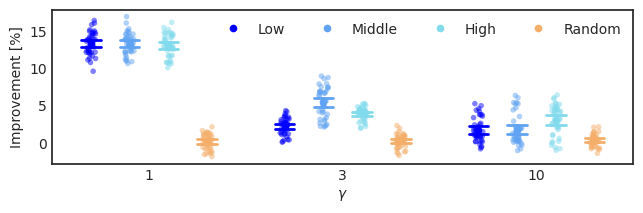

In [12]:
data_new = pd.pivot_table(data, values='Adoption Rate [%]', index=['Distance Exponent','Batch','REP'], columns='Audience Type', aggfunc="mean").reset_index()
data_new['Low'] = (data_new['low'] - data_new['No Action'])/data_new['No Action']*100
data_new['Middle'] = (data_new['middle'] - data_new['No Action'])/data_new['No Action']*100
data_new['High'] = (data_new['high'] - data_new['No Action'])/data_new['No Action']*100
data_new['Random'] = (data_new['random'] - data_new['No Action'])/data_new['No Action']*100
data_melt = pd.melt(data_new, id_vars=['Distance Exponent','Batch','REP'], value_vars=['Low','Middle','High','Random'],
        var_name='Audience Type', value_name='Adoption Rate [%]')

fig = plt.figure(figsize=(7.5,2))
axs = fig.add_subplot()
g = sns.pointplot(
    data=data_melt, x='Distance Exponent', y='Adoption Rate [%]', hue = 'Audience Type',palette=cycle(['blue', '#60a3f2', '#81dbed', '#f4ae69', '#c9623f']),
    dodge=0.6, errorbar=("se", 2), 
    markers="o", markersize=4, linestyle="none", estimator='mean', capsize=.1, linewidth=2, ax =axs
)

g = sns.stripplot(
    data=data_melt, x='Distance Exponent', y='Adoption Rate [%]', hue = 'Audience Type',palette=cycle(['blue', '#60a3f2', '#81dbed', '#f4ae69', '#c9623f']),
    dodge=0.5,  size=4,  ax =axs, legend=False, alpha = 0.5
)
plt.xlabel('$\gamma$')
plt.ylabel('Improvement [%]')
plt.legend(title="",loc ='upper right',ncols=4)

plt.savefig(os.path.join('..', 'figure', state, county, 'future_box_boost.pdf'),dpi=300,bbox_inches='tight')

In [13]:
hub_list = [1,100,200,300,400,500]
p_list = [1,10,20,30,40,50]

In [14]:
for r in [1,3,10]:
    for batch in batch_set:
        folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
        p_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder, 'parameters','p_value_star.pkl')), 'rb'), encoding='bytes')
        q_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder,'parameters','q_value_star.pkl')), 'rb'), encoding='bytes')
        
        p_low = p_value_star[0]; p_mid = p_value_star[1]; p_high = p_value_star[2]
        q_low = q_value_star[0]; q_mid = q_value_star[1]; q_high = q_value_star[2]
        
        for hub in hub_list:
            for p in p_list:
                p_value_star = [[p_low*p], [p_mid], [p_high]]
                q_value_star = [[q_low], [q_mid], [q_high]]
                par = [-1, r, 3, 3, -hub, 100, 'low']
                anna = 'cphub_'+str(hub)+'_'+str(p)+'_'+str(r)+'_'+str(batch)
                func_name = 'boost_'+anna+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
                spmob = SearchParameter(p_value_star, q_value_star, number_node, par, state, county, rep_num, 0, func_name)
                spmob.randomsearch()
                del spmob

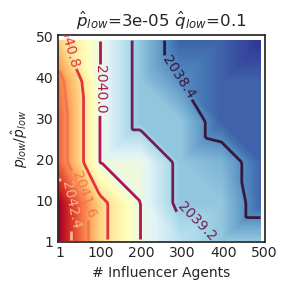

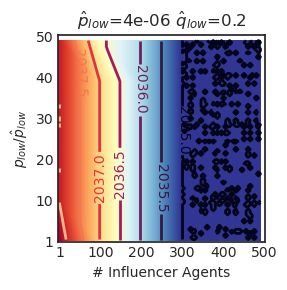

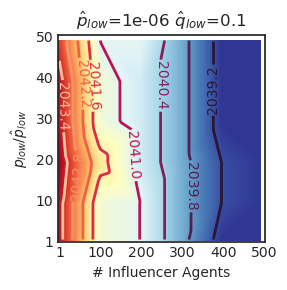

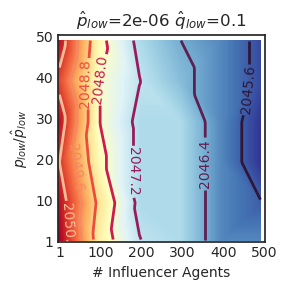

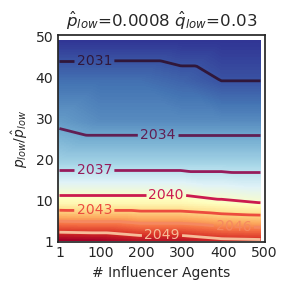

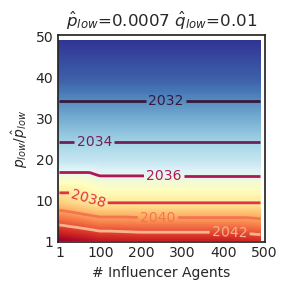

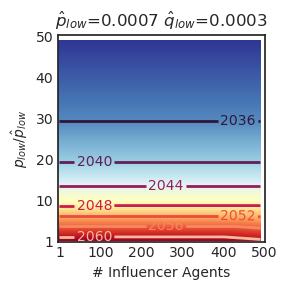

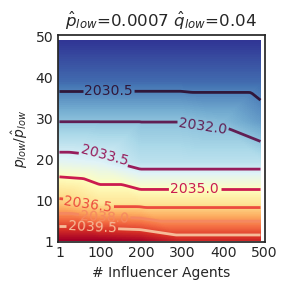

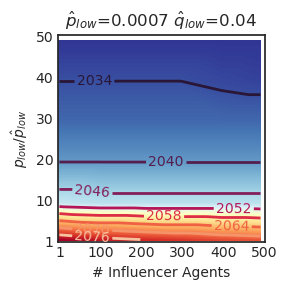

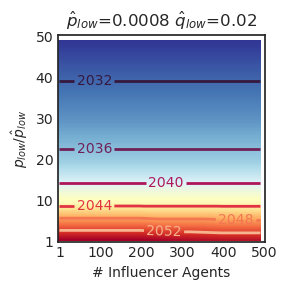

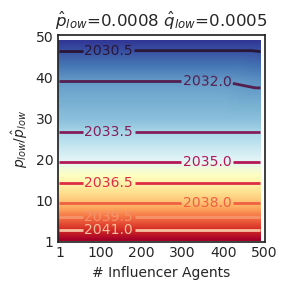

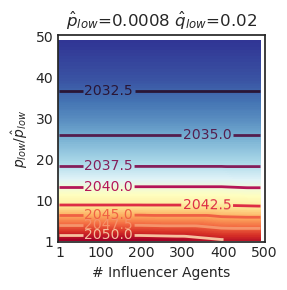

In [16]:

thr = demo.POPULATION.sum()*0.16
for r in [1,3,10]:
    for batch in batch_set:
        hubb = []; pb = []; adtb =[]; batchb = []
        folder = 'fit_pq_'+sname+'_'+str(batch)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
        p_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder, 'parameters','p_value_star.pkl')), 'rb'), encoding='bytes')
        q_value_star = pickle.load(open(os.path.realpath(os.path.join( '..', 'result', state, county, folder,'parameters','q_value_star.pkl')), 'rb'), encoding='bytes')
        
        p_low = p_value_star[0]; p_mid = p_value_star[1]; p_high = p_value_star[2]
        q_low = q_value_star[0]; q_mid = q_value_star[1]; q_high = q_value_star[2]
        
        hub_list = [1,100,200,300,400,500]
        p_list = [1,10,20,30,40,50]
        
        for hub in hub_list:
            for p in p_list:
                adt_temp = []
                par = [-1, r, 3, 3, -hub, 100, 'low']
                anna = 'cphub_'+str(hub)+'_'+str(p)+'_'+str(r)+'_'+str(batch)
                func_name = 'boost_'+anna+'_'+str(number_node)+'_'+str(par[0])+'_'+str(par[1])+'_'+str(par[2])+'_'+str(par[3])
                for rep in range(5):
                    sub_tract = (pd.read_csv(os.path.join('..','result',state, county, func_name, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale)
                    sub_tract = np.sum(sub_tract,axis=0).values
                    adt_temp.append(2010+np.argwhere(sub_tract>thr)[0][0])

                adtb.append(np.mean(adt_temp))
                hubb.append(hub)
                pb.append(p)
                batchb.append(batch)
        pqa = pd.DataFrame({'adtb':adtb, 'hubb':hubb, 'pb':pb, 'batchb':batchb})    
        pqa_batch = pd.pivot_table(pqa, values='adtb', index=['hubb','pb'], aggfunc="mean").reset_index()
        ps = pqa_batch['pb'].values; adts = pqa_batch['adtb'].values; hubs = pqa_batch['hubb'].values;     
        pqa_low = pd.DataFrame({'ps':ps, 'hubs':hubs, 'adts':adts})
        
        fig, axs = plt.subplots(nrows=1, ncols=1,
                                    sharex=False, sharey=False,
                                    figsize=(3, 3))

        grid_x, grid_y = np.mgrid[1:501:100j, 51:1:100j]
        points = np.array([hubs,ps]).transpose()
        values = adts
        grid_z = griddata(points, values, (grid_x, grid_y), method='linear')
        axs.imshow(grid_z.T,cmap='RdYlBu_r')
        CS = axs.contour(range(0,100,1), range(0,100,1), grid_z.T, c='k', linewidths = 2)
        axs.clabel(CS, inline=True, fontsize=10)
        axs.set_title('$\hat{p}_{low}$='+str(round(p_low,1))+' $\hat{q}_{low}$='+str(round(q_low,1)))
        
        p_list.reverse()
        plt.xticks(range(0,101,20), hub_list)
        plt.yticks(range(0,101,20), p_list)
        plt.xlabel('# Influencer Agents')
        plt.ylabel('$p_{low}/\hat{p}_{low}$')
        plt.tight_layout()
        plt.savefig(os.path.join('..', 'figure', state, county, 'future_contour_boost'+str(r)+str(batch)+'.pdf'),dpi=300,bbox_inches='tight')
        plt.show()